<a href="https://colab.research.google.com/github/Bmartins25/Redes_Neurais_Modelos/blob/main/Bruno_lenet5_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00


In [2]:
%load_ext watermark
%watermark -a 'Bruno Bartolomeu' -v -p torch

Author: Bruno Bartolomeu

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch: 2.0.1+cu118



## Imports

In [7]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [8]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0" #alterar após erro (Passar de 3 para 0)
GRAYSCALE = True

### MNIST Dataset

In [9]:
##########################
### MNIST DATASET
##########################

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=resize_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=resize_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [10]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [11]:
##########################
### MODEL
##########################


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(

            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [12]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
def compute_accuracy(model, data_loader, device): #treinando dados
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))



    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.3056
Epoch: 001/010 | Batch 0050/0469 | Cost: 0.5722
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.2986
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.2654
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.2659
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.1108
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.2026
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.1334
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1607
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.0795
Epoch: 001/010 | Train: 97.042%
Time elapsed: 0.50 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.1571
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0802
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0452
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0685
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.1666
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.1195
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.1153
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0418
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.1261
Epoch: 002/010 | Batch 0450/0469 

In [14]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 98.86%


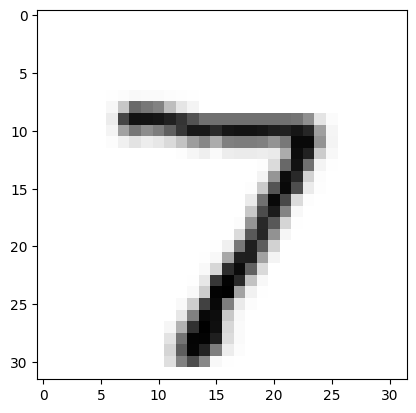

In [15]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break


nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [16]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 99.99%


In [17]:
%watermark -iv

pandas     : 1.5.3
torch      : 2.0.1+cu118
matplotlib : 3.7.1
PIL        : 9.4.0
numpy      : 1.23.5
torchvision: 0.15.2+cu118

